<a href="https://colab.research.google.com/github/rchamchong/DeepLearningTool/blob/main/Copy_of_CatAndDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# load dogs vs cats dataset, reshape and save to a new file
from zipfile import ZipFile 
import os
from google.colab import drive
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
import sys
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

def loadData(file_name):
  imgs=[]
  files=[]
  labels=[]  

  # opening the zip file in READ mode 
  with ZipFile(file_name, 'r') as zip:
    fileList=zip.namelist() # get list of filename in zip file
  #  print(fileList)

    for file in fileList:
      if not file.endswith('/'):
        with zip.open(file) as myfile: # open file from zip
          # load image
#          photo = load_img(Image.open(myfile), target_size=(200, 200))
          photo=Image.open(myfile)
          # convert to numpy array
          photo = img_to_array(photo.resize((200,200)))
          # store
          imgs.append(photo)
          files.append(file.split('/')[2])
          if 'cat' in file:
            labels.append(0)
          else:
            labels.append(1)
  # convert to a numpy arrays
  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  print('Shape of images and labels = (',imgs.shape, labels.shape, ')')

  return imgs, labels, files


file_name = os.path.join('/content/drive/Shared drives/Project61/CatDogClassification/dataDogCat/train.zip')
xData, yData, fileName=loadData(file_name)
print("fileName")

Shape of images and labels = ( (22500, 200, 200, 3) (22500,) )
fileName


In [ ]:
print(len(yData))
print(len(xData))

22500
22500


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# define cnn (Convolutional Neural Network) model 
def define_model1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# define cnn model (VGG 3layer)
def define_model2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.figure(figsize=(6,10))
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]+ '_plot.png'
	print(filename)
	plt.savefig(filename)
	plt.show()
	plt.close()

def generateData(xData, yData):
	x_train, x_valid, y_train, y_valid = train_test_split(xData, yData, test_size=0.2, random_state=1)
	del xData, yData
	# create data generator
	datagen_train = ImageDataGenerator(rescale=1.0/255.0,
#	                            height_shift_range=0.5,
#															rotation_range=90,
                              horizontal_flip=True,
 #                             zoom_range=[0.5,1.0],
                              brightness_range=[0.2,1.0])

	datagen_valid = ImageDataGenerator(rescale=1.0/255.0)
#	datagen_test = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	batch_size1=64
	train_it = datagen_train.flow(x_train, y_train, batch_size=batch_size1)
	valid_it = datagen_valid.flow(x_valid, y_valid, batch_size=32)
#	test_it = datagen_valid.flow(x_test, y_test, batch_size=64)
	return train_it, valid_it

# run the test harness for evaluating a model
def process(train_it, valid_it):
	# device_name = tf.test.gpu_device_name()
	# if device_name != '/device:GPU:0':
	# 	raise SystemError('GPU device not found')
	# print('Found GPU at: {}'.format(device_name))
	# define model
	model = define_model1()
#	model = define_model2()
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it)//64,validation_data=valid_it, validation_steps=len(valid_it)//32, epochs=30)
	
	# save model
	model.save('final_model.h5')
	# evaluate model
	_, acc = model.evaluate_generator(valid_it, steps=len(valid_it)//32)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 

In [ ]:
# main
# mount drive in google drive
drive.mount('/content/drive')
os.chdir("/content/drive/Shared drives/Project61/CatDogClassification") # change directory
path=os.getcwd() #read current directory

# specifying the zip file name 
file_name = os.path.join(path,'dataDogCat/train.zip')
print(file_name)
xData, yData, fileName=loadData(file_name)
del fileName
# save the reshaped photos
#np.save('dataDogCat/dogs_vs_cats_images.npy', imgs)
#np.save('dataDogCat/dogs_vs_cats_labels.npy', labels)
# สร้าง pandas frame
# df = pd.DataFrame({'filename': fileName})
# print('#file=%d'%(len(df)))
# out_file='dataDogCat/fileList.csv'
# df.to_csv(out_file)
# print('Save to "%s"'%out_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/Project61/CatDogClassification/dataDogCat/train.zip
Shape of images and labels = ( (22500, 200, 200, 3) (22500,) )


In [ ]:
%matplotlib inline
# generate Data
train_it, valid_it=generateData(xData,yData)
# entry point, run the test harness


Epoch 1/30
4/4 [==============================] - 1s 149ms/step - loss: 0.9746 - accuracy: 0.5078 - val_loss: 1.2464 - val_accuracy: 0.4766
Epoch 2/30
4/4 [==============================] - 0s 116ms/step - loss: 0.7530 - accuracy: 0.5039 - val_loss: 0.6965 - val_accuracy: 0.4688
Epoch 3/30
4/4 [==============================] - 0s 120ms/step - loss: 0.6935 - accuracy: 0.5117 - val_loss: 0.6673 - val_accuracy: 0.5625
Epoch 4/30
4/4 [==============================] - 0s 119ms/step - loss: 0.6920 - accuracy: 0.5039 - val_loss: 0.6726 - val_accuracy: 0.5469
Epoch 5/30
4/4 [==============================] - 0s 121ms/step - loss: 0.6876 - accuracy: 0.5391 - val_loss: 0.6822 - val_accuracy: 0.5938
Epoch 6/30
4/4 [==============================] - 0s 118ms/step - loss: 0.6826 - accuracy: 0.5430 - val_loss: 0.7345 - val_accuracy: 0.5234
Epoch 7/30
4/4 [==============================] - 0s 120ms/step - loss: 0.6842 - accuracy: 0.5430 - val_loss: 0.6867 - val_accuracy: 0.5234
Epoch 8/30
4/4 [====

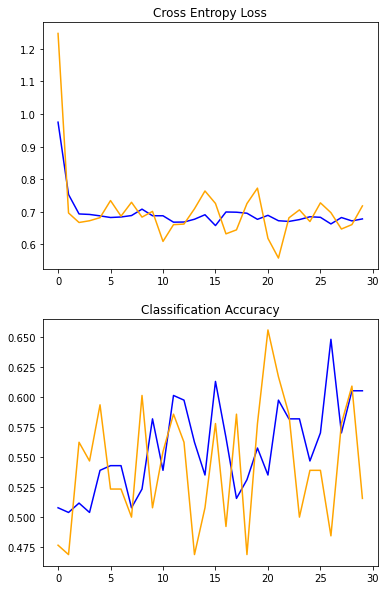

In [ ]:
process(train_it, valid_it)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/Project61/CatDogClassification/dataDogCat/test.zip
length image= 25


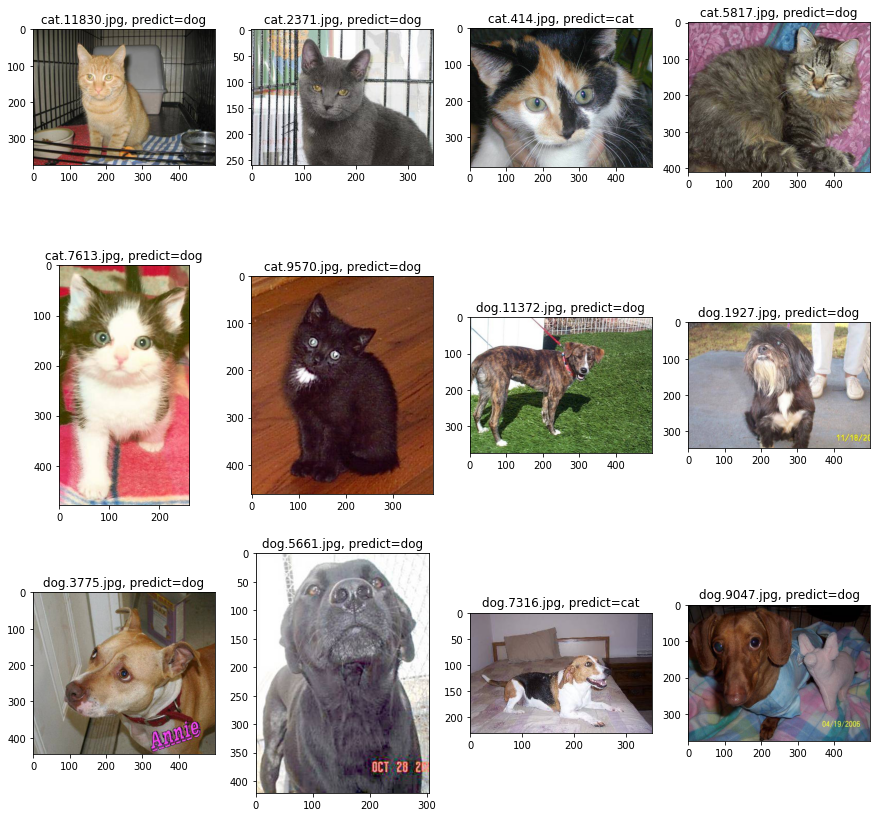

In [ ]:
#del train_it, valid_it 
# importing required modules 
%matplotlib inline
from zipfile import ZipFile 
from matplotlib.image import imread
from keras.models import load_model
from zipfile import ZipFile 
import os
from google.colab import drive
from PIL import Image
import numpy as np

drive.mount('/content/drive')
os.chdir("/content/drive/Shared drives/Project61/CatDogClassification") # change directory

path=os.getcwd() #read current directory

# specifying the zip file name 
file_name = os.path.join(path,'dataDogCat/test.zip')
print(file_name)
img=[]
fileName=[]

# opening the zip file in READ mode 
i=0
with ZipFile(file_name, 'r') as zip:
  fileList=zip.namelist() # get list of filename in zip file

  for file in fileList:
    if not file.endswith('/'):
      with zip.open(file) as myfile: # open file from zip
        if i%100==0:
          img.append(Image.open(myfile)) # get image data of file from zipfile
#          print(file, img.size, img.mode, len(img.getdata()))
          fileName.append(file.split('/')[2])
        i+=1

print('length image=',len(img))
#img=img_to_array(img)
model = load_model('final_model.h5')
# plot cat photos from the dogs vs cats dataset
# plot first few images
for i in range(1,13):
  # predict the class
  image=img_to_array(img[i*2].resize((200,200)))
  
#  image.reshape(1, 200, 200, 3)
  image=np.expand_dims(image, 0)
  result = model.predict(image)
  if result[0]==0:
    out='cat'
  else:
    out='dog'
	# define subplot
  plt.figure(1,figsize=(15,15))
  plt.subplot(3,4,i)
  # plot raw pixel data
  plt.imshow(img[i*2])
  plt.title(fileName[i*2]+', predict='+out)
# show the figure
plt.show()
